In [1]:
# import time
# import copy
import torch
import warnings
warnings.filterwarnings('ignore')
# import torch_geometric

from torch import nn, optim
from torch.nn import functional as F
from torch_geometric import nn as gnn
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import ModelNet
from IPython.display import display, clear_output
# from torch_geometric.utils import remove_self_loops
# from sklearn.model_selection import train_test_split
from torch_geometric.transforms import Compose, RandomRotate, SamplePoints, KNNGraph, NormalizeScale

import numpy as np
import matplotlib.pyplot as plt

from model import GNN, PNET, PointNet, PointViG, PointNet2, List

torch.manual_seed(seed=42)

In [3]:
print(torch.version.cuda)
print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

12.4
2.4.1+cu124
cuda


In [4]:
# Hyperparameters

batch_size = 16
n_samples = 2048

degrees, axes = [180, 180, 180], [0, 1, 2]

NUM_CLASSES = 10
ratio_1, radius_1 = .748, .4817
ratio_2, radius_2 = .3316, .2447
dropout = .1

class_names = List([
	'bathtub', 'bed', 'chair', 'desk', 'dresser', 
	'monitor', 'night_stand', 'sofa', 'table', 'toilet'
])

EPOCHS = 10
lr = .0001
weight_decay = 0


In [5]:
class JitterTransform:
	def __init__(self, std=.001, clip=.05):
		self.std = std
		self.clip = clip

	def __call__(self, data):
		jitter = torch.rand(data.pos.shape) * self.std
		# jitter = torch.clamp(jitter, -self.clip, self.clip)
		data.pos += jitter
		return data
jitter = JitterTransform()

class ShuffleTransform:
	def __init__(self):
		pass

	def __call__(self, data):
		num_points = data.pos.shape[0]
		shuffle_idx = torch.randperm(num_points)
		data.pos = data.pos[shuffle_idx]
		return data
	
shuffle = ShuffleTransform()

In [6]:
list_of_rotations = [RandomRotate(degrees=i, axis=j) for i, j in zip(degrees, axes)]
random_rotate = Compose(list_of_rotations)


pre_transform = NormalizeScale()
transform = Compose([
	# random_rotate,
	# jitter,
	# shuffle,
	SamplePoints(num=n_samples),
	# KNNGraph(k=6),
])

train_data = ModelNet('ModelNet/',
					  name='10',
					  transform=transform,
					  pre_transform=pre_transform,
					  train=True)

val_data = ModelNet('ModelNet/',
					name='10',
					transform=transform,
					pre_transform=pre_transform,
					train=False)

dataloader = DataLoader(dataset=train_data,
						batch_size=batch_size,
						shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
							shuffle=False,
							batch_size=batch_size)

# Test DataLoader output
for batch in dataloader:
	print(f"Batch shape: {batch.pos.shape}")  # Should print [batch_size, n_samples, 3]
	pos_reshaped = batch.pos.view(batch_size, n_samples, 3)
	print(f"Batch shape: {pos_reshaped.shape}")  # Should print [batch_size, n_samples, 3]
	
	break

Batch shape: torch.Size([32768, 3])
Batch shape: torch.Size([16, 2048, 3])


In [7]:
# model = GNN(3, [16, 32, 64], NUM_CLASSES, class_names, aggr='mean')
# model = PNET(3, [64, 128, 256], NUM_CLASSES, class_names, aggr='mean')
# model = PointNet(in_channels=3, out_channels=NUM_CLASSES)
# model = PointViG(3, 10)

model = PointNet2(ratio_1, ratio_2, radius_1, radius_2, dropout)

model = model.to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
model

1463626


PointNet2(
  (sa1_module): SetAbstraction(
    (conv): PointNetConv(local_nn=MLP(3, 64, 64, 128), global_nn=None)
  )
  (sa2_module): SetAbstraction(
    (conv): PointNetConv(local_nn=MLP(131, 128, 128, 256), global_nn=None)
  )
  (sa3_module): GlobalSetAbstraction(
    (nn): MLP(259, 256, 512, 1024)
  )
  (mlp): MLP(1024, 512, 256, 10)
)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.NLLLoss()

In [9]:
metrics = {
	'epoch_train_loss': [],
	'epoch_val_loss': [],
	'epoch_train_acc': [],
	'epoch_val_acc': [],
}

def unsqueeze_batch(e):
	y = e.y
	e = e.pos.view(int(e.pos.shape[0] / n_samples), n_samples, 3)
	e = e.transpose(1, 2)
	return e, y

def transform_input(e):
	y = e.y
	# e = e.pos.view(int(e.pos.shape[0] / n_samples), n_samples, 3)
	# e = e.transpose(1, 2)
	return e, y

def accuracy(y, y_hat):
	return (y == y_hat).type(torch.float).mean().item()

def train_epoch(m, epoch):
	m.train()
	loss = 0

	batch_acc = []
	batch_loss = []
	
	for i, e in enumerate(dataloader):
		e = e.to(device)

		e, y = transform_input(e)

		o = m(e)
		y_hat = o.argmax(dim=-1)
		

		loss = criterion(o, y)
		# loss = loss + reg_weight * reg_loss

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		batch_acc.append(accuracy(y, y_hat))  # .detach().item())
		batch_loss.append(loss.detach().item())

		# wandb.log({
		# 	f"batch_train_loss (epoch {epoch})": batch_loss[-1],
		# 	f"batch_train_acc (epoch {epoch})": batch_acc[-1],
		# 	f"batch_train (epoch {epoch})": i,
		# })

		e = e.to('cpu')
		torch.cuda.empty_cache()
	
	epoch_acc, epoch_loss = sum(batch_acc) / len(batch_acc), sum(batch_loss) / len(batch_loss)
	
	metrics['epoch_train_loss'].append(epoch_loss)
	metrics['epoch_train_acc'].append(epoch_acc)

	# wandb.log({
	# 	"epoch_train_loss": epoch_loss,
	# 	"epoch_train_acc": epoch_acc,
	# 	"epoch_train": epoch,
	# })
	
	return epoch_acc, epoch_loss

def val_epoch(m, epoch):
	m.eval()

	loss = 0

	batch_acc = []
	batch_loss = []

	for i, e in enumerate(val_dataloader):
		e = e.to(device)

		e, y = transform_input(e)

		o = m(e)
		y_hat = o.argmax(dim=-1)
		

		loss = criterion(o, y)
		
		batch_acc.append(accuracy(y, y_hat))
		batch_loss.append(loss.detach().item())

		# wandb.log({
		# 	f"batch_val_loss (epoch {epoch})": batch_loss[-1],
		# 	f"batch_val_acc (epoch {epoch})": batch_acc[-1],
		# 	f"batch_val (epoch {epoch})": i,
		# })

		e = e.to('cpu')
		torch.cuda.empty_cache()
	
	epoch_acc, epoch_loss = sum(batch_acc) / len(batch_acc), sum(batch_loss) / len(batch_loss)
	
	metrics['epoch_val_loss'].append(epoch_loss)
	metrics['epoch_val_acc'].append(epoch_acc)

	# wandb.log({
	# 	"epoch_val_loss": epoch_loss,
	# 	"epoch_val_acc": epoch_acc,
	# 	"epoch_val": epoch,
	# })
	
	return epoch_acc, epoch_loss
	
def train(m):	

	for epoch in range(EPOCHS):
		epoch_train_acc, epoch_train_loss = train_epoch(m, epoch)
		epoch_val_acc, epoch_val_loss = val_epoch(m, epoch)

		torch.cuda.empty_cache()

		str_print = f'[{epoch + 1}/{EPOCHS}]: loss - {epoch_train_loss:.4f}, train accuracy - {epoch_train_acc:.4f}, val accuracy - {epoch_val_acc:.4f}'
		print(str_print + ' ' * max(100 - len(str_print), 0), end='\n')
		# plot()

	torch.cuda.empty_cache()
	
def initialize_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# model.apply(initialize_weights)

train(model)

[1/10]: loss - 1.1158, train accuracy - 0.6278, val accuracy - 0.7599                               
[2/10]: loss - 0.3682, train accuracy - 0.8660, val accuracy - 0.8246                               
[3/10]: loss - 0.2633, train accuracy - 0.9042, val accuracy - 0.8761                               
[4/10]: loss - 0.2178, train accuracy - 0.9203, val accuracy - 0.8925                               
[5/10]: loss - 0.1823, train accuracy - 0.9303, val accuracy - 0.8772                               
[6/10]: loss - 0.1501, train accuracy - 0.9423, val accuracy - 0.8838                               
[7/10]: loss - 0.1448, train accuracy - 0.9485, val accuracy - 0.8794                               
[8/10]: loss - 0.1258, train accuracy - 0.9539, val accuracy - 0.8871                               
[9/10]: loss - 0.1234, train accuracy - 0.9550, val accuracy - 0.8955                               
[10/10]: loss - 0.1080, train accuracy - 0.9593, val accuracy - 0.9145                     

In [89]:
fig, (ax, loss_ax) = None, (None, None)

# def plot():
# 	global fig, ax, loss_ax
# 	if fig is None:
# 		fig, (ax, loss_ax) = plt.subplots(1, 2, figsize=(16, 9))

# 	ax.clear()
# 	clear_output()

# 	if len(metrics['epoch_train_acc']) == 1:
# 		ax.scatter([1], metrics['epoch_train_acc'], label='train accuracy')
# 		ax.scatter([1], metrics['epoch_val_acc'], label='validation accuracy')
# 	else:	
# 		ax.plot(metrics['epoch_train_acc'], label='train accuracy')
# 		ax.plot(metrics['epoch_val_acc'], label='validation accuracy')

# 	ax.legend()

# 	loss_ax.clear()
# 	loss_ax.yaxis.grid(color=(.05, .05, .05, .2), linestyle='solid')

# 	clear_output()

# 	if len(metrics['epoch_train_loss']) == 1:
# 		loss_ax.scatter([1], metrics['epoch_train_loss'], label='train loss')
# 		loss_ax.scatter([1], metrics['epoch_val_loss'], label='validation loss')
# 	else:
# 		loss_ax.plot(metrics['epoch_train_loss'], label='train loss')
# 		loss_ax.plot(metrics['epoch_val_loss'], label='validation loss')
	
# 	loss_ax.legend()
# 	ax.yaxis.grid(color=(.05, .05, .05, .2), linestyle='solid')

# 	display(fig)
# 	plt.pause(0.2)


def plot():
	global fig, ax, loss_ax
	if fig is None:
		fig, (ax, loss_ax) = plt.subplots(1, 2, figsize=(16, 9))

	ax.clear()
	ax.plot(metrics['epoch_train_acc'], label='train accuracy')
	ax.plot(metrics['epoch_val_acc'], label='validation accuracy')

	ax.legend()
	ax.yaxis.grid(color=(.05, .05, .05, .2), linestyle='solid')


	loss_ax.clear()
	loss_ax.plot(metrics['epoch_train_loss'], label='train loss')
	loss_ax.plot(metrics['epoch_val_loss'], label='validation loss')
	
	loss_ax.legend()
	loss_ax.yaxis.grid(color=(.05, .05, .05, .2), linestyle='solid')

	plt.show()


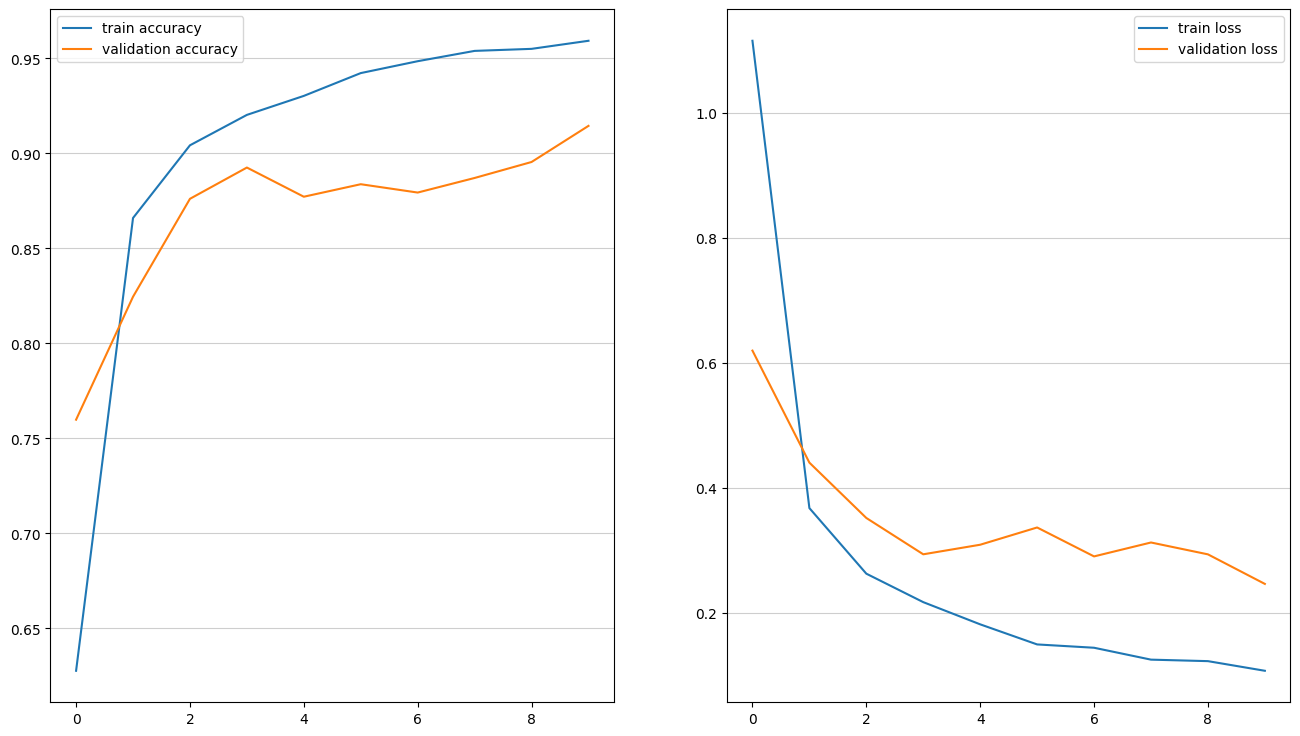

In [90]:
plot()

In [203]:
shuffled_loader = DataLoader(dataset=val_data,
							shuffle=True,
							batch_size=batch_size)

In [244]:
miss_classified = []
miss_classes = []

for i, e in enumerate(shuffled_loader):
	e = e.to(device)
	o = model(e).argmax(dim=-1)

	mask = ~(o == e.y).cpu()
	falseClassPtr = np.where(mask.numpy())[0]
	
	print(f'[{len(miss_classes)}/10]: {100 * len(miss_classes)/10:.2f}%', end='r')

	for ptr in falseClassPtr:
		miss_classified.append(e.pos[e.ptr[ptr]:e.ptr[ptr+1]].cpu().clone())
		miss_classes.append({'predicted': class_names[o[ptr].item()], 'actual': class_names[e.y[ptr].item()]})

	if len(miss_classes) >= 10:
		break




[10/10]: 100%


In [245]:
hit_classified = []
hit_classes = []

for i, e in enumerate(shuffled_loader):
	e = e.to(device)
	o = model(e).argmax(dim=-1)

	mask = (o == e.y).cpu()
	trueClassPtr = np.where(mask.numpy())[0]

	print(f'[{len(hit_classes)}/10]: {100 * len(hit_classes)/10:.2f}%', end='r')

	for ptr in trueClassPtr[:10]:
		hit_classified.append(e.pos[e.ptr[ptr]:e.ptr[ptr+1]].cpu().clone())
		hit_classes.append({'predicted': class_names[o[ptr].item()], 'actual': class_names[e.y[ptr].item()]})


	if len(hit_classes) >= 10:
		break

[10/10]: 100%


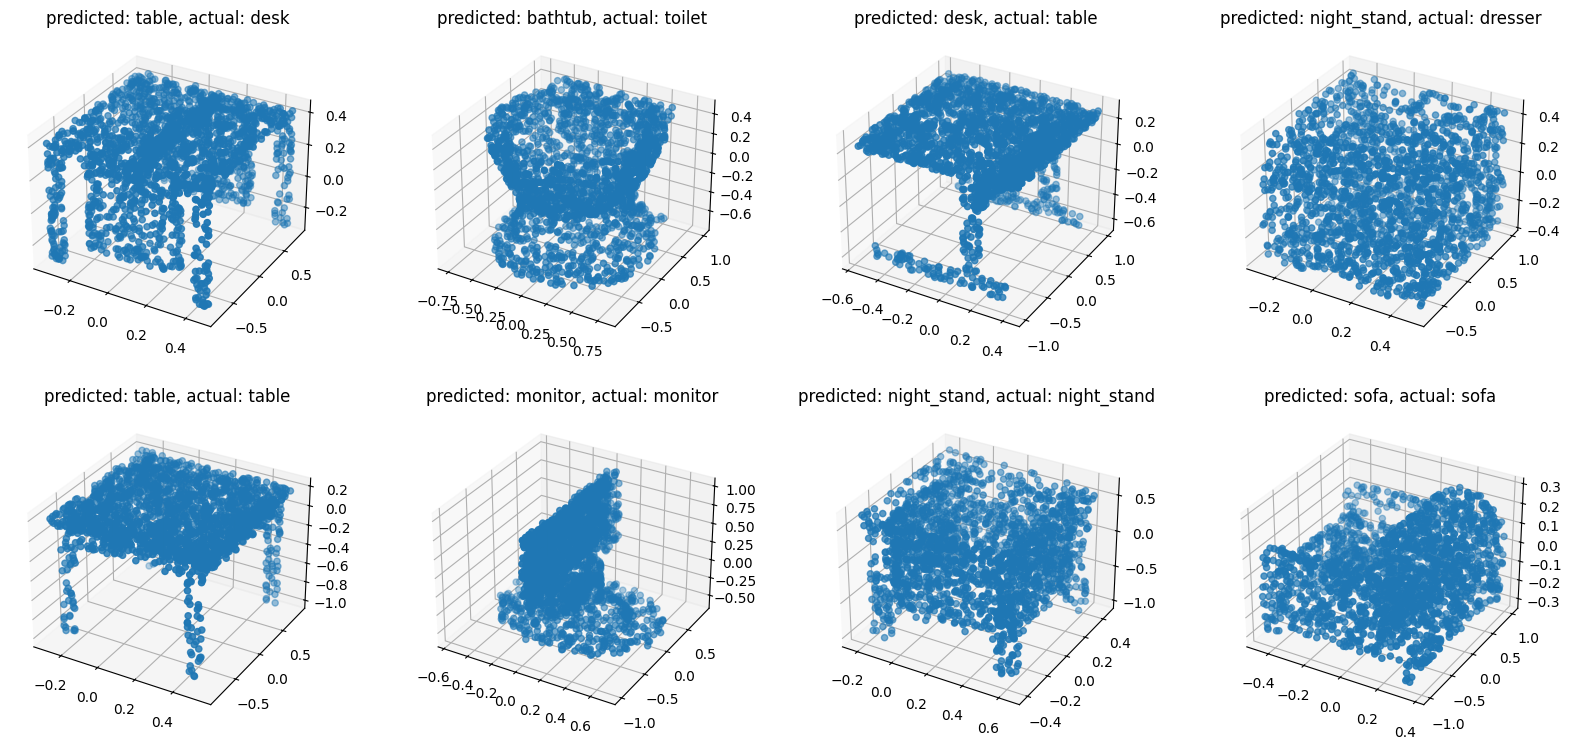

In [242]:
cloud_fig = plt.figure(figsize=(20, 9))
cloud_fig.tight_layout()

n_cols = 4
n_rows = 2


for idx, e in enumerate(miss_classified[:n_cols]):
	cloud_ax = cloud_fig.add_subplot(n_rows, n_cols, idx+1, projection='3d')
	cloud_ax.scatter(e[:, 0],
					e[:, 1],
					e[:, 2])
	cloud_ax.set_title(f"predicted: {miss_classes[idx]['predicted']}, actual: {miss_classes[idx]['actual']}")

for idx, e in enumerate(hit_classified[:n_cols]):
	cloud_ax = cloud_fig.add_subplot(n_rows, n_cols, n_cols+idx+1, projection='3d')
	cloud_ax.scatter(e[:, 0],
					e[:, 1],
					e[:, 2])
	cloud_ax.set_title(f"predicted: {hit_classes[idx]['predicted']}, actual: {hit_classes[idx]['actual']}")


In [246]:
torch.save(model.state_dict(), "PointNet++.pkl")